In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import random

In [3]:
np.random.seed(42)

n_samples = 1000

industries = ['Retail', 'Tech', 'Manufacturing', 'Healthcare', 'Logistics']
countries = ['UK', 'Germany', 'France', 'Nigeria', 'India']

data = {
    'invoice_amount': np.random.exponential(scale=5000, size=n_samples).round(2),  # Skewed distribution
    'due_days': np.random.randint(15, 90, size=n_samples),
    'client_industry': np.random.choice(industries, size=n_samples),
    'issuer_country': np.random.choice(countries, size=n_samples),
    'client_credit_score': np.random.randint(20, 100, size=n_samples),
    'prior_invoice_count': np.random.randint(0, 50, size=n_samples),
    'prior_default_rate': np.round(np.random.uniform(0, 0.5, size=n_samples), 2),
    'season': np.random.choice(['Q1', 'Q2', 'Q3', 'Q4'], size=n_samples)
}

df = pd.DataFrame(data)
# Logic to assign defaults
def calculate_default(row):
    base_risk = 0.05
    if row['client_credit_score'] < 40:
        base_risk += 0.25
    if row['invoice_amount'] > 10000:
        base_risk += 0.1
    if row['prior_default_rate'] > 0.3:
        base_risk += 0.2
    if row['client_industry'] in ['Retail', 'Logistics']:
        base_risk += 0.05
    return np.random.rand() < base_risk  # Returns True (1) or False (0)

df['defaulted'] = df.apply(calculate_default, axis=1).astype(int)

In [4]:
df.head()

,invoice_amount,due_days,client_industry,issuer_country,client_credit_score,prior_invoice_count,prior_default_rate,season,defaulted
0,2346.34,61,Tech,India,73,41,0.18,Q3,0
1,15050.61,26,Retail,France,94,26,0.07,Q1,1
2,6583.73,76,Retail,India,49,10,0.30,Q3,0
3,4564.71,22,Manufacturing,India,67,37,0.41,Q4,0
4,848.12,35,Healthcare,UK,54,33,0.19,Q3,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   invoice_amount       1000 non-null   float64
 1   due_days             1000 non-null   int32  
 2   client_industry      1000 non-null   object 
 3   issuer_country       1000 non-null   object 
 4   client_credit_score  1000 non-null   int32  
 5   prior_invoice_count  1000 non-null   int32  
 6   prior_default_rate   1000 non-null   float64
 7   season               1000 non-null   object 
 8   defaulted            1000 non-null   int64  
dtypes: float64(2), int32(3), int64(1), object(3)
memory usage: 58.7+ KB


In [6]:
df.describe()

,invoice_amount,due_days,client_credit_score,prior_invoice_count,prior_default_rate,defaulted
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4862.529810,50.667000,60.194000,24.713000,0.248540,0.233000
std,4862.549616,21.701868,22.924177,14.304309,0.144416,0.422954
min,23.210000,15.000000,20.000000,0.000000,0.000000,0.000000
25%,1345.780000,31.000000,40.000000,13.000000,0.130000,0.000000
50%,3433.915000,50.000000,60.000000,24.000000,0.240000,0.000000
75%,6819.150000,70.000000,80.000000,37.000000,0.370000,0.000000
max,40862.230000,89.000000,99.000000,49.000000,0.500000,1.000000


In [7]:
df[['defaulted']].value_counts()

defaulted
0            767
1            233
Name: count, dtype: int64

## Class Distribution
### How many clients defaulted vs not?

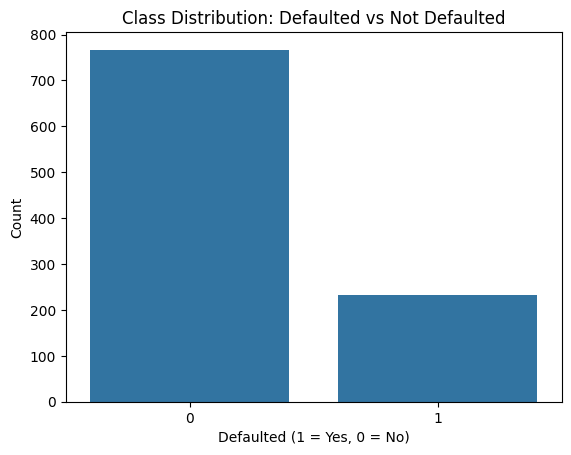

Default rate: 23.30%


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='defaulted', data=df)
plt.title('Class Distribution: Defaulted vs Not Defaulted')
plt.xlabel('Defaulted (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

# Percentages
default_rate = df['defaulted'].mean() * 100
print(f"Default rate: {default_rate:.2f}%")


## Numerical Features Distributions
### Relationships between features and default. 

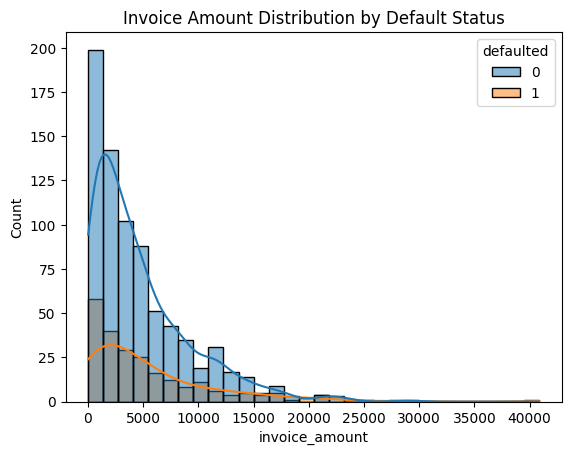

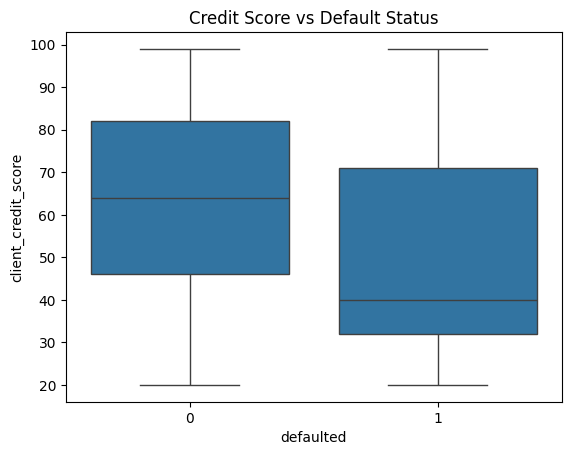

In [9]:
# Histogram comparison for invoice amount
sns.histplot(data=df, x='invoice_amount', hue='defaulted', kde=True, bins=30)
plt.title('Invoice Amount Distribution by Default Status')
plt.show()

# Boxplots for comparison
sns.boxplot(x='defaulted', y='client_credit_score', data=df)
plt.title('Credit Score vs Default Status')
plt.show()


## Categorical features distributions


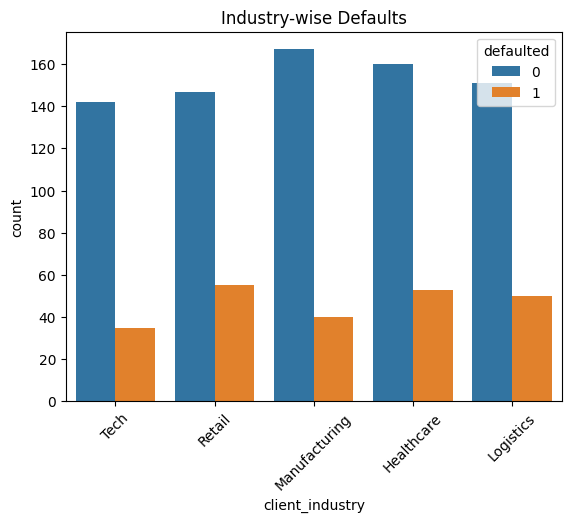

In [10]:
# Industry vs default
sns.countplot(x='client_industry', hue='defaulted', data=df)
plt.title('Industry-wise Defaults')
plt.xticks(rotation=45)
plt.show()


## Correlation Heatmap
### This helps to understand relationships.

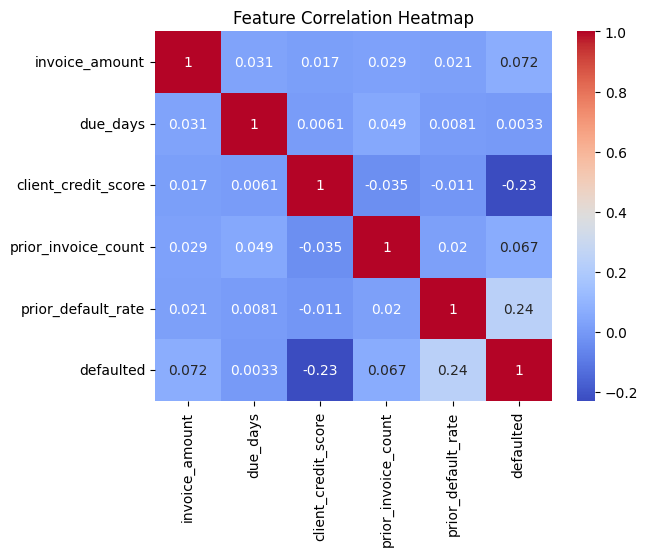

In [11]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


# Model Building

## A classification approach using Random forest classifier 

### STEP 1: Split the data into Predictor variable (X) i.e invoice_amount, due_days,prior_default_rate etc. And Target varible(y) i.e defaulted

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop('defaulted', axis=1)
y = df['defaulted']


### STEP 2: Encode Categorical Features - For the model to work accurately, we will convert the Categorical features in X to Numerical features using get_dummies() method.


In [16]:
 X = pd.get_dummies(X, drop_first=True)


### STEP 3: Split the data into training and testing set using the Train-Test Split feature.
#### Train set is 80% while test set is 20% of the data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### STEP 4: Evaluation of the model performance using classification report and confusion matrix


### Classification Report

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print(classification_report(y_test, rf_pred))


              precision    recall  f1-score   support

           0       0.78      0.93      0.85       153
           1       0.39      0.15      0.22        47

    accuracy                           0.74       200
   macro avg       0.58      0.54      0.53       200
weighted avg       0.69      0.74      0.70       200



### 📈 Model’s Performance
Class 0: Non-defaulters
Precision: 0.78 → 78% of the time, when the model predicted no default, it was right.

Recall: 0.93 → It captured 93% of all true non-defaulters.

F1-score: 0.85 → Strong overall performance for identifying payers.

Class 1: Defaulters
Precision: 0.39 → Only 39% of predicted defaulters were correct.

Recall: 0.15 → It only caught 15% of actual defaulters.

F1-score: 0.22 → Poor performance in identifying defaulters.

### Confusion Matrix

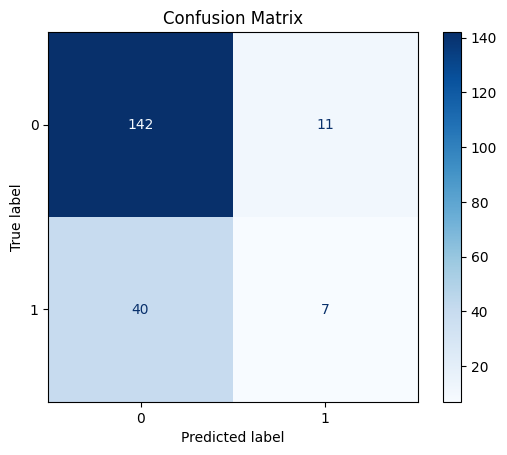

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### 🔍 Model Prediction Breakdown:

The model made the following predictions on the test set:

✅ True Positives (142): The model correctly predicted 142 times that a customer would not default on payment.

❌ False Positives (11): It incorrectly predicted 11 times that a customer would not default, when in fact they did.

✅ True Negatives (40): The model correctly identified 40 cases where a customer would default.

❌ False Negatives (7): It mistakenly predicted 7 customers would default, when they actually paid on time.

## Conclusion

This project explored how machine learning can help predict invoice payment defaults — a crucial problem for investors and platforms in the alternative finance space.

Using simulated data, we trained a **Random Forest Classifier** to predict whether a client would default on an invoice. This model was selected for its ability to handle non-linear relationships, reduce overfitting, and deliver more stable results than a single decision tree.

### Key findings:
- The model achieved **74% accuracy**.
- It performed **very well at identifying non-defaulters** (high precision and recall).
- However, it struggled with correctly identifying defaulters — likely due to **class imbalance** in the data.

### Next steps:
- Use **resampling techniques** like SMOTE or class-weight adjustments to improve performance on the minority (defaulter) class.
- Experiment with hyperparameter tuning or other ensemble models like **XGBoost**.
- Add additional real-world or alternative data features (e.g., payment history trends, macro indicators).

This project demonstrates how machine learning can support **risk assessment in invoice trading**, helping investors make more informed funding decisions.
